In [146]:
import numpy as np
from numpy.fft import fft
import pandas as pd
import matplotlib.pyplot as plt
import zlib 
import scipy as sp

In [128]:
import pandas as pd

df = pd.read_csv('csv/Turntable1.csv')

In [130]:
t = df[['Time']].to_numpy()
accX = df[['Accel X (g)']].to_numpy()
temp = df[['Temp']].to_numpy()
gyroZ = df[['Gyro Z (dps)']].to_numpy()
gravY = df[['Grav Y']].to_numpy()

In [131]:
def get_fft(x):
    sr = 2*len(x)
    X = fft(x)
    N = len(X)
    n = np.arange(N)
    T = N/sr
    f = n/T

    return f, X

def plot_fft(f, X, title='x(t)'):
    plt.stem(f, np.abs(X), 'b', markerfmt=' ', basefmt='b')
    plt.title(f'FFT of {title} vs Frequency')
    plt.ylabel(f'Magnitude |FFT({title})|')
    plt.xlabel('Frequency [Hz]')

def plot_time(t, x, title='x(t)'):
    plt.plot(t, x)
    plt.title(f'{title} vs time')
    plt.xlabel('Time [s]')
    plt.ylabel(f'{title}')

def plot_all(t, x):
    plt.figure(figsize=(10, 7))
    plt.subplot(211)
    plot_time(t, x)
    plt.subplot(212)
    f, X = get_fft(x)
    plot_fft(f, X)

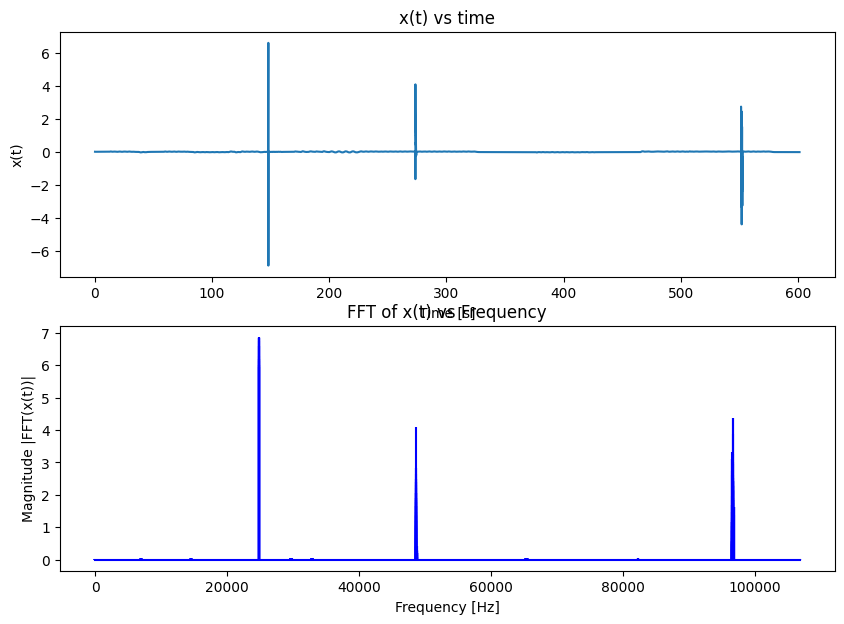

In [133]:
plot_all(t, gravY)

In [152]:
X = sp.fft.fft(accX)


53397

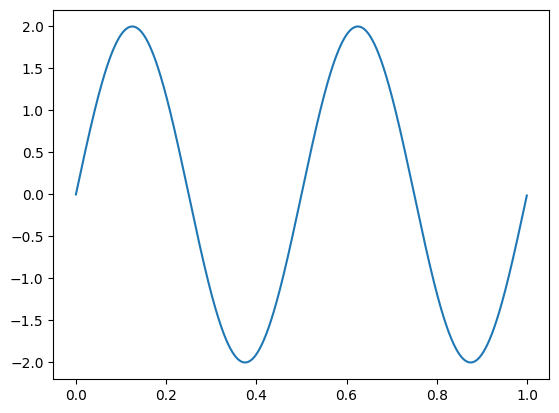

In [135]:
sr = 2000
ts = 1.0/sr
t = np.arange(0, 1, ts)
omega = 2*np.pi*2
x = 2*np.sin(omega*t)
plt.plot(t, x)

(0.0, 10.0)

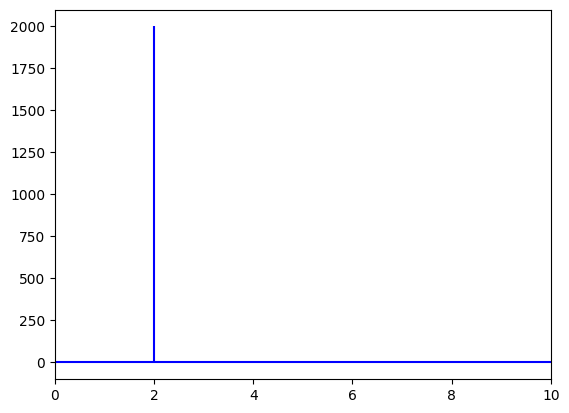

In [136]:
X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
f = n/T

plt.stem(f, np.abs(X), 'b', markerfmt=' ', basefmt='b')
plt.xlim(0, 10)


In [140]:
x

array([ 0.        ,  0.01256629,  0.02513208, ..., -0.03769688,
       -0.02513208, -0.01256629])

In [141]:
X

array([-2.01568201e-14+0.00000000e+00j, -4.85551218e-15+5.43143610e-14j,
       -2.41950822e-13-2.00000000e+03j, ...,
        5.62578971e-15+9.87713636e-14j, -2.74282488e-13+2.00000000e+03j,
       -4.85551218e-15-5.43143610e-14j])

## Compression

In [215]:
def compress(plaintext, level):
    comp = zlib.compress(plaintext.encode('utf-8'), level)
    return comp

In [216]:
with open('csv_as_text/WalkingAround.txt') as f:
    original = f.readlines()


In [217]:
compressed = []
for line in original:
    comp = compress(line, 8)
    compressed.append(comp)

In [218]:
with open('compressed/WalkingAround_compressed.txt', 'wb') as f:
    f.writelines(compressed)

In [219]:
decompressed = []
for line in compressed:
    decomp = zlib.decompress(line)
    decompressed.append(decomp)

In [220]:
with open('decompressed/WalkingAround_decompressed.txt', 'wb') as f:
    f.writelines(decompressed)

In [221]:
with open('csv_as_text/WalkingAround.txt') as f:
    original_file = f.read()

with open('decompressed/WalkingAround_decompressed.txt') as f:
    decompressed_file = f.read()

In [222]:
if original_file==decompressed_file:
    print('All data retained after compression and decompression')
else:
    print('Insufficient data retained after compression and decompression')

All data retained after compression and decompression


## Encryption

In [207]:
from Crypto.Cipher import AES
from secrets import token_bytes
import time

#generate key
key = token_bytes(16)

#encrypt function
def encrypt(msg):
    cipher = AES.new(key, AES.MODE_EAX)
    nonce = cipher.nonce
    ciphertext, tag = cipher.encrypt_and_digest(msg.encode('ascii'))
    return nonce, ciphertext, tag

#decrypt function
def decrypt(nonce, ciphertext, tag):
    cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
    plaintext = cipher.decrypt(ciphertext)
    try:
        cipher.verify(tag)
        return plaintext.decode('ascii')
    except:
        return False

#function to check if decrypted data is the same as the original data
def check_decryption(plaintext, original):
    if plaintext == original:
        print('Decryption Successful')
    else:
        print('Decryption Failed')

#timing function
def get_time():
    t = time.perf_counter()
    return t

def do_encryption(filenames, timing=False, generate_files=False):
    for file in filenames:
        #read text file as a string
        with open('csv_as_text/'+file) as f:
            original = f.read()
    
        start = get_time()
        #encrypt data
        nonce, ciphertext, tag = encrypt(original)
        stop = get_time()
        encrypt_time = round(stop-start, 4) 
        
        start = get_time()
        #decrypt data
        plaintext = decrypt(nonce, ciphertext, tag)
        stop = get_time()
        decrypt_time = round(stop-start, 4)

        total_time = encrypt_time+decrypt_time

        #generate textfiles
        if generate_files:
            with open('encrypted/encrypted_'+file+'.txt', 'w') as f:
                f.writelines(str(ciphertext))

            start = get_time()
            with open('decrypted/decrypted_'+file+'.txt', 'w') as f:
                f.writelines(str(plaintext))
            stop = get_time()
            write_time = round(stop-start, 4)
            total_time += write_time

        print(f'Checking Decryption for {file}')
        check_decryption(plaintext, original)

        if timing:
            print(f'Encrption Execution Time {encrypt_time} seconds')
            print(f'Decryption Execution Time {decrypt_time} seconds')
            if generate_files:
                print(f'Time to write to text file {write_time} seconds')
            print(f'Total Execution Time {total_time} seconds')

        print('-------------------------------------')